# Web Scraping the NYC Marathon (2018)

### NYC Marathon 2018 - USA Men's Results

The goal of this notebook is to extract, clean, manipulate, and visualize web data using Python's libraries. Specifically, I will be analyzing the 2018 results for top 100 USA men who competed in the NYC Marathon.

Source: https://www.tcsnycmarathon.org/about-the-race/results/usa-men

In [2]:
## Import Statements
import pandas as pd 
import numpy as np
import re

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Retrieving Data

In [3]:
## Setting up Web Scraping

# link for overall men's results 
url = 'https://www.tcsnycmarathon.org/about-the-race/results/usa-men'

# getting around mod_security or some similar server security feature
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

# loading html
html = urlopen(req).read()

Credit for resolving "HTTP Error 403: Forbidden' : https://stackoverflow.com/questions/16627227/http-error-403-in-python-3-web-scraping/47966786

In [4]:
# creating soup object with html parser set to 'lxml'
soup = BeautifulSoup(html, 'lxml')

# printing the type of the soup object
type(soup)

bs4.BeautifulSoup

### Cleaning Data

In [5]:
## Generate an empty list, extract text inbetween html tags for each row, and append to list

# finding all of the table rows
table_rows = soup.find_all('tr')

# creating an empty list for the rows
rows_list = list()

for row in table_rows:
    cells = row.find_all('td')                              # finding all table cells
    str_cells = str(cells)                                  # converting from list
    clean_text = BeautifulSoup(str_cells, 'lxml').get_text()
    clean_text = clean_text.replace('\n\t\t\t\t', '')       # removing new line/tabs
    #clean_text = clean_text.replace('[', '')                # removing brackets
    #clean_text = clean_text.replace(']', '')                # removing brackets
    rows_list.append(clean_text)

In [6]:
## Inspecting the first few rows
rows_list[:5]

['[Place, Bib, Name, Time, State, Country, Citizenship]',
 '[7, 3, Abdi Abdirahman, 2:12:48, AZ, United States, USA]',
 '[10, 12, Shadrack Biwott, 2:14:57, CA, United States, USA]',
 '[11, 11, Meb Keflezighi, 2:15:29, CA, United States, USA]',
 '[12, 9, Jared Ward, 2:18:39, UT, United States, USA]']

In [7]:
## We can see that is it a list of strings, not al list of lists, this is an issue
print(type(rows_list[1]))

<class 'str'>


In [8]:
## Easiest way (through trial and error) to convert the list of strings (of lists) into list
df_list = []
for x in rows_list:
    junkers = re.compile('[[" \]]')
    result = junkers.sub('', x).split(',')
    df_list.append(result)
    
    
# https://stackoverflow.com/questions/1894269/convert-string-representation-of-list-to-list

#### Pandas DataFrame

In [9]:
# columns names   (for some reason, as you can see below, there are 8 columns)
column_names = df_list[0] + ["None"]


# loading DataFrame
df = pd.DataFrame(df_list, columns=column_names)

# inspecting first few lines
df.head()

,Place,Bib,Name,Time,State,Country,Citizenship,None
0,Place,Bib,Name,Time,State,Country,Citizenship,None
1,7,3,AbdiAbdirahman,2:12:48,AZ,UnitedStates,USA,None
2,10,12,ShadrackBiwott,2:14:57,CA,UnitedStates,USA,None
3,11,11,MebKeflezighi,2:15:29,CA,UnitedStates,USA,None
4,12,9,JaredWard,2:18:39,UT,UnitedStates,USA,None


In [10]:
df.tail()

,Place,Bib,Name,Time,State,Country,Citizenship,None
97,232,608,StephenYoung,2:45:21,FL,UnitedStates,USA,None
98,238,1545,TopherGaylord,2:45:33,MD,UnitedStates,USA,None
99,239,1029,ChasePizzonia,2:45:38,NY,UnitedStates,USA,None
100,240,3151,AndrewRoach,2:45:41,MD,UnitedStates,USA,None
101,,None,None,None,None,None,None,None


In [11]:
df.shape

(102, 8)

In [12]:
# dropping the first row because it contians the column names
df = df.drop([0]) 

# Bad entry "68	154	1208	RobertWiegand	Jr	2:42:30	IL	UnitedStates"
df = df.drop([68])

# last row full of NaN's
df = df.drop([101])
df = df.drop(['None'], axis=1)

In [13]:
## Again inspecting
df.head(2)

,Place,Bib,Name,Time,State,Country,Citizenship
1,7,3,AbdiAbdirahman,2:12:48,AZ,UnitedStates,USA
2,10,12,ShadrackBiwott,2:14:57,CA,UnitedStates,USA


In [14]:
# inspecting data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 1 to 100
Data columns (total 7 columns):
Place          99 non-null object
Bib            99 non-null object
Name           99 non-null object
Time           99 non-null object
State          99 non-null object
Country        99 non-null object
Citizenship    99 non-null object
dtypes: object(7)
memory usage: 6.2+ KB


In [15]:
## Changing data types to proper data types
df.Place = pd.to_numeric(df.Place)

df.Bib = pd.to_numeric(df.Bib)

In [16]:
print(df.Time[1])

2:12:48


In [17]:
## Manually correcting one entry: 68, 154,1208,RobertWiegand	Jr	2:42:30	IL,UnitedStates
# df.loc[68].Time ="2:42:20"
# df.loc[68].State = "IL"
# df.loc[68].Country = "UnitedStates"
# df.loc[68].Citizenship = 'USA'

In [18]:
## Having a lot of trouble using pd.to_datetime
# Wont convert to just hours, minutes, and seconds but rather starts with year, month, day

# ex.)  1900-01-01 02:12:48

# df.Time = pd.to_datetime(df.Time, format='%H:%M:%S', errors='coerce')

In [19]:
### Calculating the the total minutes of each runner's time for mathematical analysis.

time_in_minutes = []

for time in df.Time:
    t = time.split(':')
    
    hours, minutes, sec = t[0], t[1], t[2]
    total_mins = (int(hours) * 3600 + int(minutes) * 60 + int(sec)) / 60
    time_in_minutes.append(total_mins)

In [20]:
df['Minutes'] = time_in_minutes

In [21]:
df.head()

,Place,Bib,Name,Time,State,Country,Citizenship,Minutes
1,7,3,AbdiAbdirahman,2:12:48,AZ,UnitedStates,USA,132.800000
2,10,12,ShadrackBiwott,2:14:57,CA,UnitedStates,USA,134.950000
3,11,11,MebKeflezighi,2:15:29,CA,UnitedStates,USA,135.483333
4,12,9,JaredWard,2:18:39,UT,UnitedStates,USA,138.650000
5,15,18,BrendanMartin,2:22:36,NY,UnitedStates,USA,142.600000


### Exploratory Data Analysis

In [27]:
df.describe()

,Place,Bib,Minutes
count,99.000000,99.000000,99.000000
mean,116.575758,1141.383838,158.039057
std,64.027273,922.014816,6.788641
min,7.000000,3.000000,132.800000
25%,66.000000,550.000000,155.358333
50%,109.000000,1070.000000,159.233333
75%,168.500000,1394.000000,163.016667
max,240.000000,7081.000000,165.683333


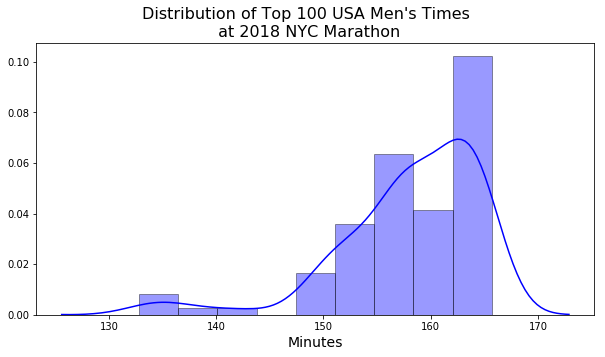

In [29]:
## Distribution Plot
f = plt.figure(figsize=(10,5))

sns.distplot(df.Minutes, hist=True, kde=True, 
             rug=False, color='b', bins=int(np.sqrt(len(df.Time))), 
             hist_kws={'edgecolor':'black'}
            )

plt.suptitle("Distribution of Top 100 USA Men's Times\n at 2018 NYC Marathon",
             fontsize=16)

plt.xlabel("Minutes", fontsize=14)

plt.savefig("MinutesDistribution.png")

plt.show()

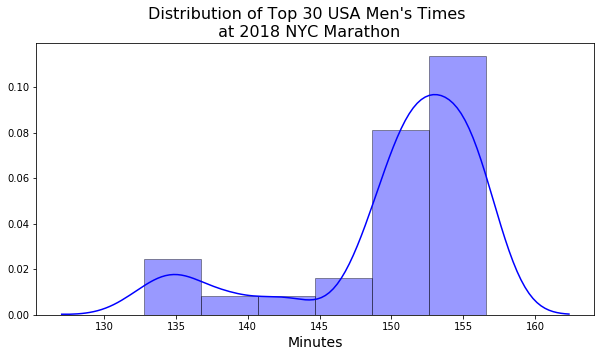

In [24]:
## Distribution Plot
f = plt.figure(figsize=(10,5))

sns.distplot(df.Minutes[:31], hist=True, kde=True, 
             rug=False, color='b', bins=6, 
             hist_kws={'edgecolor':'black'}
            )

plt.suptitle("Distribution of Top 30 USA Men's Times\n at 2018 NYC Marathon",
             fontsize=16)

plt.xlabel("Minutes", fontsize=14)
plt.show()

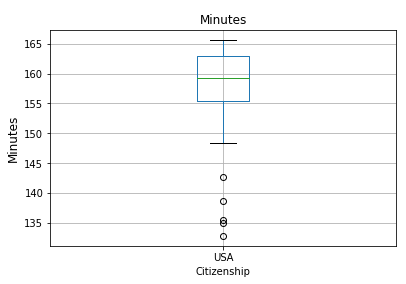

In [26]:
df.boxplot(column='Minutes', by='Citizenship')

plt.suptitle(" ")

plt.ylabel("Minutes", fontsize=12)
plt.show()

/home/adam/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


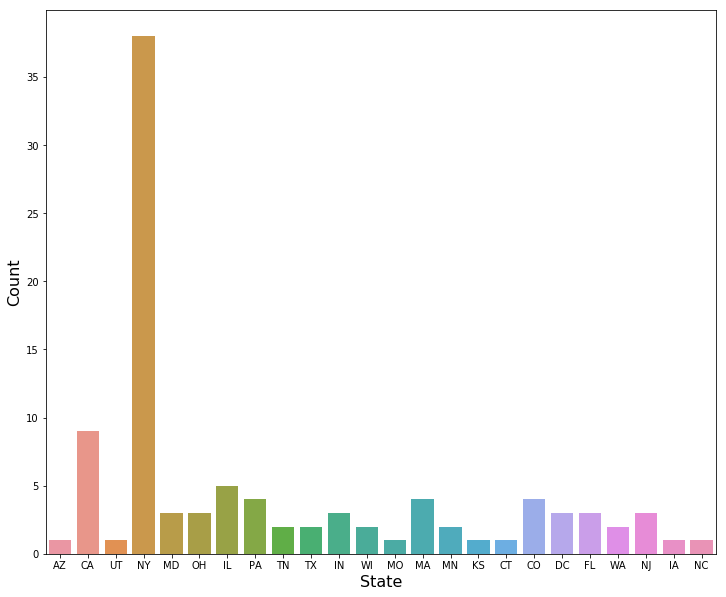

In [28]:
f = plt.figure(figsize=(12,10))

sns.countplot(x='State', data=df.dropna())



plt.ylabel("Count", fontsize=16)
plt.xlabel("State", fontsize=16)

plt.show()

### Conclusion

In [ ]:
states = df.groupby(by="State").count()

In [ ]:
top_ten_states = states.sort_values(by="Place", ascending=False).head(10)
top_ten_states

1. The state with the highest number of top 100 runners was New York (38). California had the second most (9).
2. 50% of the top 100 USA Mens finishers had a time between 155 and 163 minutes while the winner ran it in 132.8 and the slowest at 165.8